# Import Library

In [1]:
import os
import json
import numpy as np
import cv2, zlib, base64, io
from PIL import Image
from PIL import ImageColor

import gc
import sys
import glob
import random
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

import itertools
from tqdm import tqdm
from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

# Setup Base

### Dowload Libraries and Pretrained Weights

In [2]:
#!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('/kaggle/working/Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

In [ ]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

In [3]:
# SOURCE BASE PATH
ROOT_DIR = Path('/kaggle/working')
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

ROOT_DATA_DIR = Path('/kaggle/input/food103superviselyformat/dataFood103Ninja')
META_JSON = os.path.join(ROOT_DATA_DIR, 'meta.json')
NUM_CLASS = 103
IMAGE_SIZE = 512

In [4]:
sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Set Config

In [5]:
class FoodsConfig(Config):
    NAME = "foods"
    NUM_CLASSES = NUM_CLASS + 1
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 200
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE  
    
config = FoodsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                116
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

# CUSTOM DATASET

In [6]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask

In [7]:
class FoodsDataset(utils.Dataset):
    
    def load_foods(self, dataset_dir, subset):
        
        assert subset in ["train", "test"]
        
        f = open(META_JSON)
        class_data = json.load(f)
        
        for i, category in enumerate(class_data['classes']):
            self.add_class("foods", i, category['title'])
            
        DATA_DIR = os.path.join(ROOT_DATA_DIR, subset)
        ANN_DIR = os.path.join(DATA_DIR, 'ann')
        IMG_DIR = os.path.join(DATA_DIR, 'img')
        
        for img_file in os.listdir(IMG_DIR):    
            f = open(os.path.join(ANN_DIR, img_file + ".json"))
            ann = json.load(f)
            
            self.add_image(
                "foods", 
                image_id = img_file,
                path = os.path.join(IMG_DIR, img_file),
                width = ann['size']["width"], 
                height = ann['size']["height"],
                objects = ann['objects']
            )
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])
        
    def load_mask(self, image_id):
        image_infor = self.image_info[image_id]
        
        instance_masks = []
        category_ids = []
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(image_infor["objects"])), dtype=np.uint8)

        for index, obj in enumerate(image_infor["objects"]):
            main_mask = np.full(image_infor['height'] * image_infor['width'], 0, dtype=np.uint8)
            instance_mask = base64_2_mask(obj['bitmap']['data'])
            x, y = [int(b) for b in obj['bitmap']['origin']]
            
            for j, yy in enumerate(instance_mask):
                for i, xx in enumerate(yy):
                    if xx:     
                        main_mask[image_infor['height'] * (x + i) + y + j] = 1
            main_mask = main_mask.reshape((image_infor['height'], image_infor['width']), order='F')
            main_mask = cv2.resize(main_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            mask[:,:,index] = main_mask
            
            category_ids.append(self.class_names.index(obj['classTitle']))
    
        category_ids = np.array(category_ids, dtype=np.int32)
        
        return mask, category_ids

# VISUALIZED DATASET


(512, 512, 6)


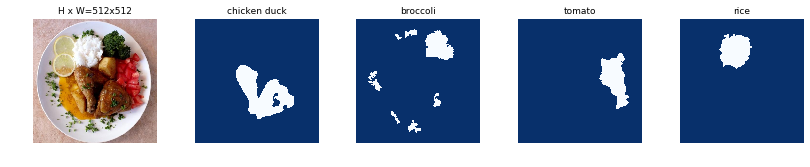


(512, 512, 5)


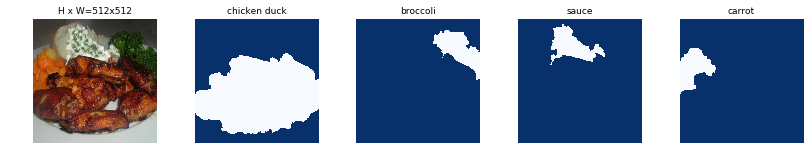


(512, 512, 2)


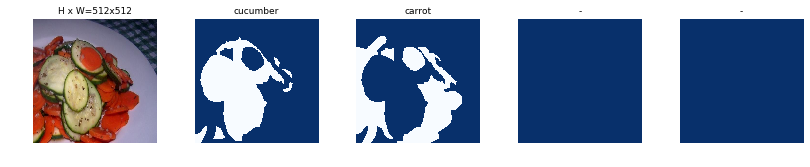


(512, 512, 5)


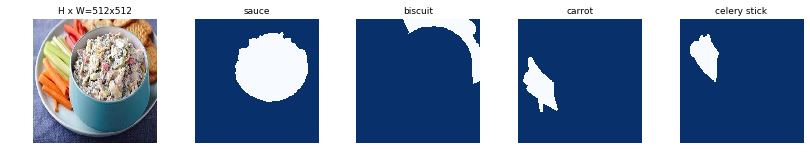


(512, 512, 3)


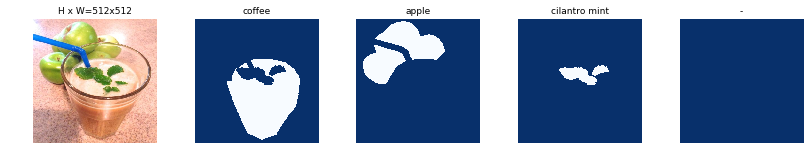


(512, 512, 3)


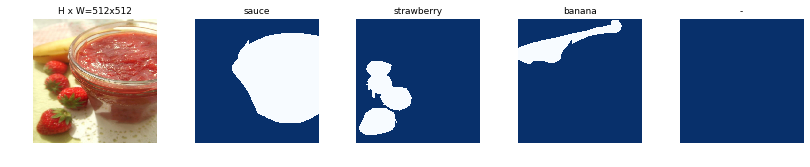


(512, 512, 3)


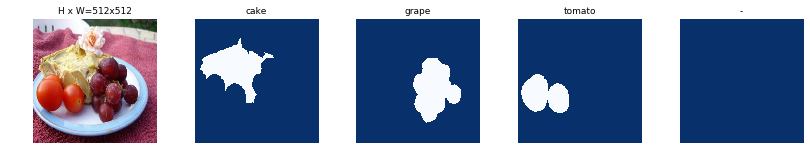


(512, 512, 6)


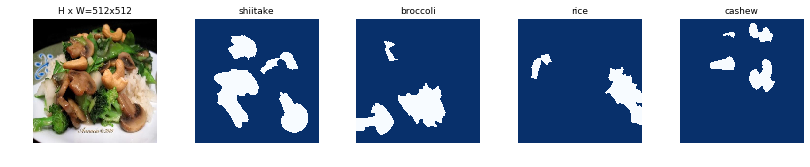


(512, 512, 3)


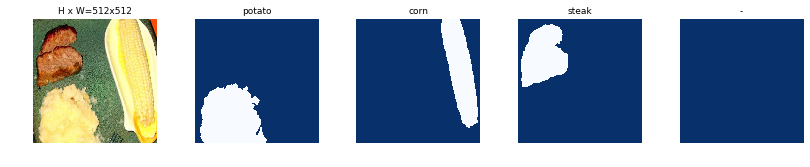


(512, 512, 4)


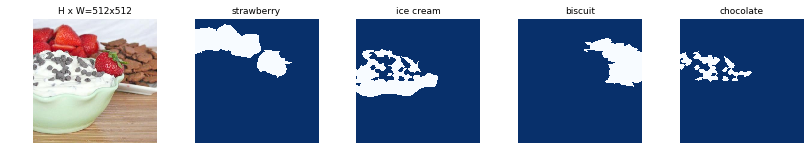


(512, 512, 2)


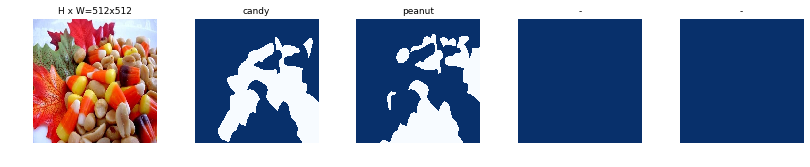


(512, 512, 2)


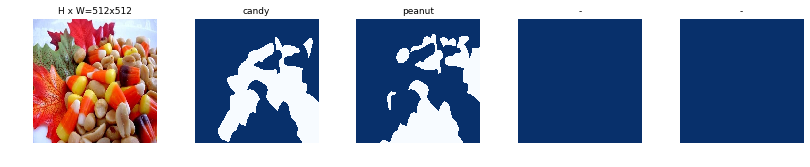


(512, 512, 3)


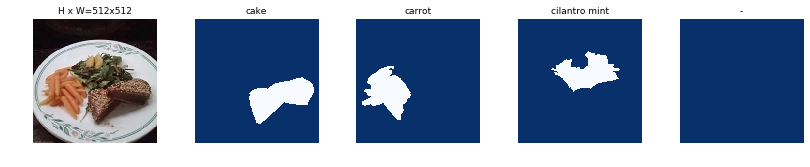


(512, 512, 3)


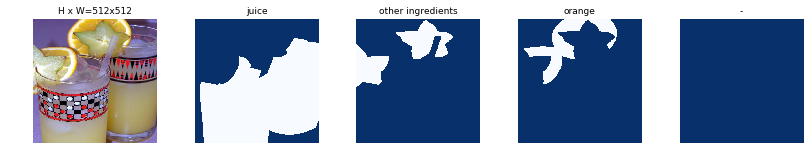


(512, 512, 6)


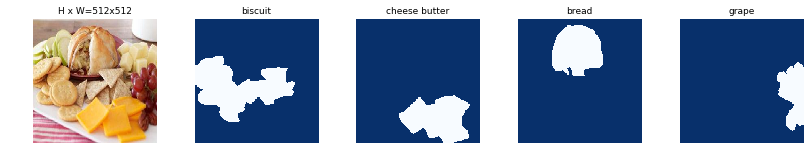


(512, 512, 6)


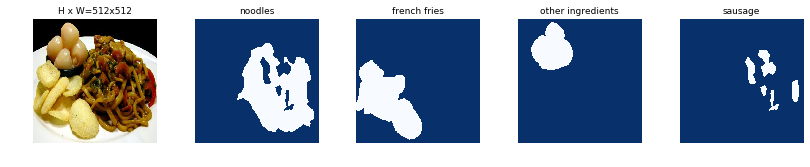


(512, 512, 6)


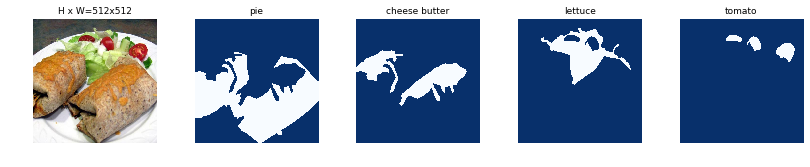


(512, 512, 2)


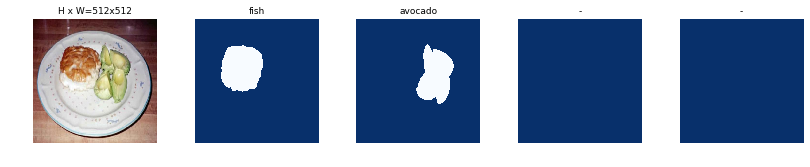


(512, 512, 5)


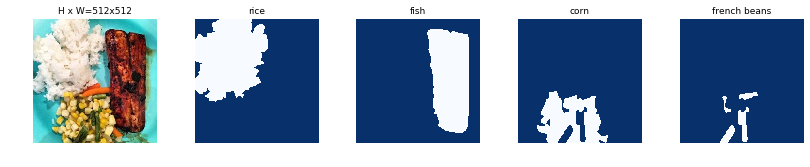


(512, 512, 2)


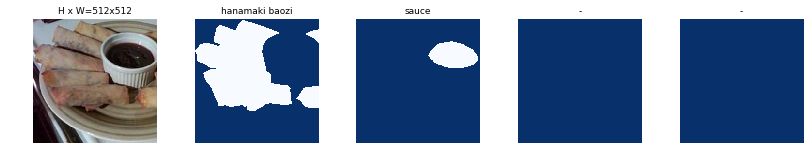

In [8]:
dataset_val = FoodsDataset()
dataset_val.load_foods(ROOT_DATA_DIR, "test")
dataset_val.prepare()
for i in range(20):
    image_id = random.choice(dataset_val.image_ids)
    print(dataset_val.image_reference(image_id))
    
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

image id is : 1880
image ID: foods.00005791.jpg (1880) 


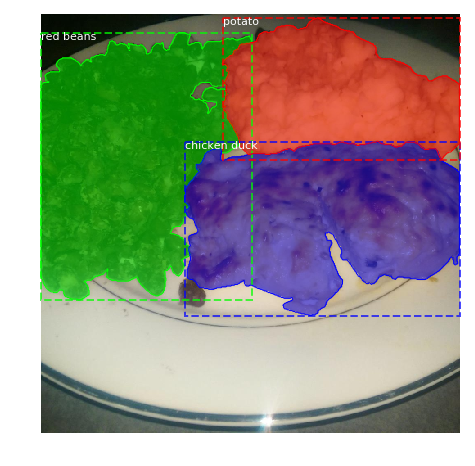

In [9]:
#RUN DETECTION
image_id = random.choice(dataset_val.image_ids)
#image_id = 'D:/MaskRCNN-aar/Dataset/val/1.jfif'
print("image id is :",image_id)
image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset_val.image_reference(image_id)))
visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))

# Prepare Training Dataset

In [ ]:
# Note that any hyperparameters here, such as LR, may still not be optimal
LR = 1e-4
EPOCHS = [6, 12, 20, 30, 42, 60]
#10 8 4 2 1 /2

import warnings 
warnings.filterwarnings("ignore")

In [8]:
config = FoodsConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
        # Download weights file
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

# Training dataset.
dataset_train = FoodsDataset()
dataset_train.load_foods(ROOT_DATA_DIR, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = FoodsDataset()
dataset_val.load_foods(ROOT_DATA_DIR, "test")
dataset_val.prepare()

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5) # only horizontal flip here
])

In [ ]:
model.get_trainable_layers()[10]

# Training

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LR * 10, # train heads with higher lr to speedup learning
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LR * 8,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LR * 4,
            epochs=EPOCHS[2],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LR * 2,
            epochs=EPOCHS[3],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LR,
            epochs=EPOCHS[4],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

In [ ]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate = LR / 5,
            epochs=EPOCHS[5],
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]

# Predict

In [9]:
glob_list = glob.glob(f'/kaggle/input/weight/Weight/mask_rcnn_foods_0025.h5')
model_path = glob_list[0] if glob_list else ''

In [17]:
class InferenceConfig(FoodsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

assert model_path != '', "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/input/weight/Weight/mask_rcnn_foods_0025.h5


In [11]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

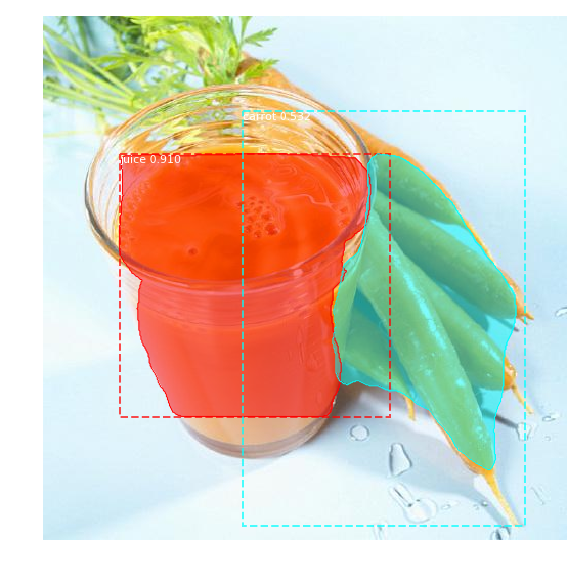

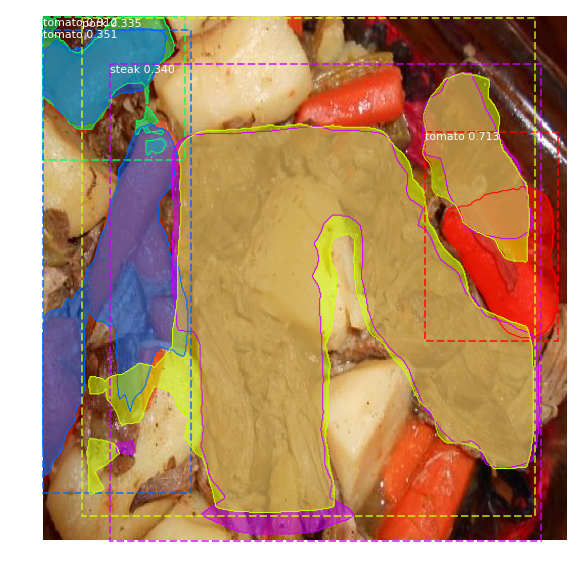

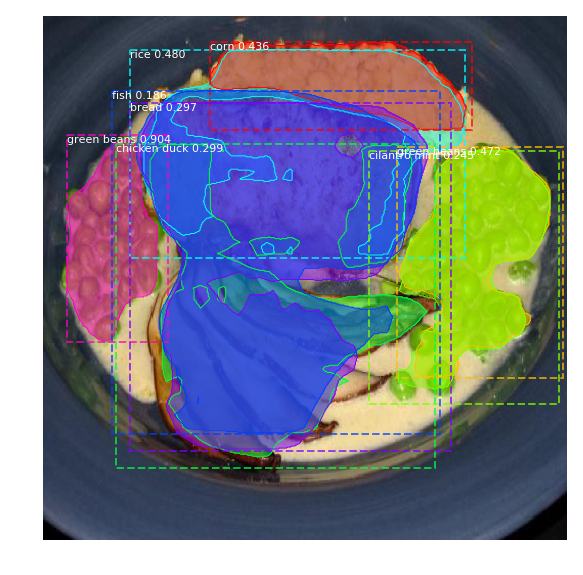

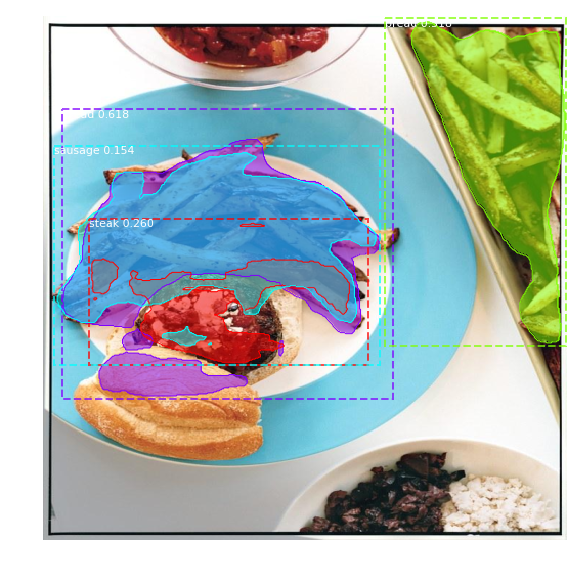

In [14]:
for i in range(4):
    image_id = np.random.choice(dataset_val.image_ids, 1)[0]
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    original_image = cv2.resize(original_image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)                         
    r = model.detect([original_image])
    r = r[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((original_image.shape[0], original_image.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = original_image.shape[0]/IMAGE_SIZE
        x_scale = original_image.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(10, 10))
        

In [5]:
!python --version
import tensorflow
!tensorflow --version

Python 3.6.6 :: Anaconda, Inc.
/bin/sh: 1: tensorflow: not found


In [10]:
print(dataset_val.class_names)

['BG', 'almond', 'apple', 'apricot', 'asparagus', 'avocado', 'bamboo shoots', 'banana', 'bean sprouts', 'biscuit', 'blueberry', 'bread', 'broccoli', 'cabbage', 'cake', 'candy', 'carrot', 'cashew', 'cauliflower', 'celery stick', 'cheese butter', 'cherry', 'chicken duck', 'chocolate', 'cilantro mint', 'coffee', 'corn', 'crab', 'cucumber', 'date', 'dried cranberries', 'egg', 'eggplant', 'egg tart', 'enoki mushroom', 'fig', 'fish', 'french beans', 'french fries', 'fried meat', 'garlic', 'ginger', 'grape', 'green beans', 'hamburg', 'hanamaki baozi', 'ice cream', 'juice', 'kelp', 'king oyster mushroom', 'kiwi', 'lamb', 'lemon', 'lettuce', 'mango', 'melon', 'milk', 'milkshake', 'noodles', 'okra', 'olives', 'onion', 'orange', 'other ingredients', 'oyster mushroom', 'pasta', 'peach', 'peanut', 'pear', 'pepper', 'pie', 'pineapple', 'pizza', 'popcorn', 'pork', 'potato', 'pudding', 'pumpkin', 'rape', 'raspberry', 'red beans', 'rice', 'salad', 'sauce', 'sausage', 'seaweed', 'shellfish', 'shiitake',

[[ 16 298 400 424]
 [ 28  68 218 250]
 [ 26  44 220 248]
 [191  26 465 317]
 [173  22 468 310]
 [180  12 479 304]]
sdfaj
[[  8 149 200 212]
 [ 14  34 109 125]
 [ 13  22 110 124]
 [ 95  13 232 158]
 [ 86  11 234 155]
 [ 90   6 239 152]]
[[  8 149 198 209]
 [ 22  34 101 123]
 [ 23  27  99 119]
 [105  25 226 139]
 [104  14 217 139]
 [108  25 214 141]]


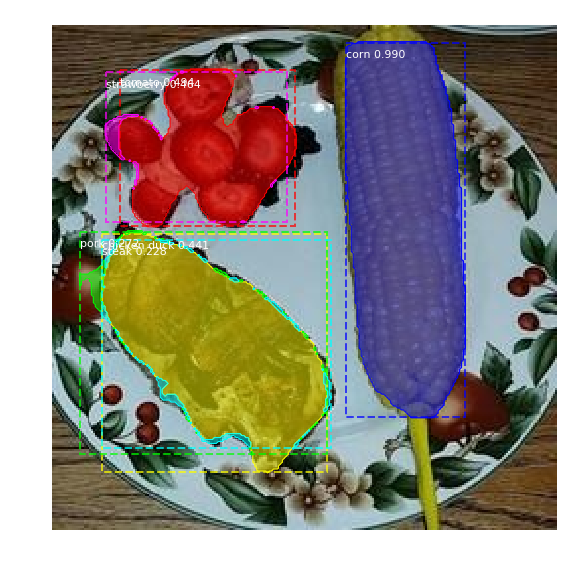

In [20]:
image_path = "/kaggle/input/food103superviselyformat/dataFood103Ninja/test/img/00004413.jpg"
original_image = cv2.imread(image_path)

img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)                         
r = model.detect([img])
r = r[0]

if r['masks'].size > 0:
    masks = np.zeros((original_image.shape[0], original_image.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    y_scale = original_image.shape[0]/IMAGE_SIZE
    x_scale = original_image.shape[1]/IMAGE_SIZE
    print(r['rois'])
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
    print("sdfaj")
    print(rois)

    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']

# print(r['class_ids'])
# print(masks.shape)
# print(original_image.shape)
print(rois)
# print(r['scores'])

visualize.display_instances(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), rois, masks, r['class_ids'], dataset_val.class_names, r['scores'], figsize=(10, 10))
    

In [ ]:
image_id = np.random.choice(dataset_val.image_ids, 1)[0]
    
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

original_image = cv2.resize(original_image, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)                         
r = model.detect([original_image])
r = r[0]

if r['masks'].size > 0:
    masks = np.zeros((original_image.shape[0], original_image.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    y_scale = original_image.shape[0]/IMAGE_SIZE
    x_scale = original_image.shape[1]/IMAGE_SIZE
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)

    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(10, 10))
